# Part - 2 : Automatic Cloth Body Tag Labelling

*Yilin Lyu*

*yl3832@columbia.edu*

This jupyter notebook describes the automatic labeling process of labelling the image in the **Body-Grid view.csv**

### This work was done by:

1) **Scrap and Download** all the images from the Internet.

2) Use **KNN** to find the closest descriptions to the target image.

        2.1) Example

3) **Save** the tags to csv file.

        3.1) Label all the images in the dataset
        3.2) Visualizations of the results
             3.3.1) Word cloud
             3.3.2) Barplot of top body tags

In [ ]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import os
import math
import cv2
import collections
import random
import webcolors
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from __future__ import division
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import collections

In [15]:
data = pd.read_csv("Body-Grid view.csv")
#data = pd.read_csv("Body-Grid_view_labeled.csv")
data.head()

,Body Name,IMAGE,Product Tags: Body,Core Body Number,TAG: Body,id
0,ZIP HOODIE,EH2KTK9Qeer0hHk66aon_Screen%20Shot%202018-01-0...,NaN,CM-3003,NaN,recS4t29J73BYrznq
1,Zip BaseBall Jacket,uZNESfIgQLu2lhCVJy2X_Screen%20Shot%202017-12-2...,NaN,CM-4001,NaN,recLupRsEop46s4ME
2,Zara Girl's Dress Shirt,CuVfganJSF6x3NCSZuWQ_RM%20PLACEHOLDER.jpg (htt...,NaN,RM-3001,NaN,recujzUss1l8UxyjY
3,Zara Girl's Bottom,i6nSRSDdRgaVGrvSvLnM_RM%20PLACEHOLDER.jpg (htt...,NaN,RM-2001,NaN,recJo98wKtjScdpxy
4,Zara Boy's Dress Shirt,ww1VVxblTKnWsQGP0zL1_RM%20PLACEHOLDER.jpg (htt...,NaN,RM-3000,NaN,reczC3Lul6lJNkOvG


## 1 ) Download all the images from the Internet 

In [126]:
def get_image(data_path, get_training = True):
    '''
    This function download all the image from the database to local machine
    It will extract url information from the table and download corresponding images with id as name
    '''
    data = pd.read_csv(data_path)
    image = data['IMAGE']
    type_list = ['png','jpg','JPG','JPEG','PNG']
    if get_training:
        image = image[-data['TAG: Body'].isnull()]
        image = image[-image.isna()]
        ids = data['id'][image.index]
        if not os.path.exists('body_train'):
            os.makedirs('body_train')
        for s,name in zip(image,ids):
            file_name = name + '.png'
            save_path = os.path.join('body_train',file_name)
            if file_name in os.listdir('body_train'):
                continue
            url = s[s.find("http"):len(s)-1]
            if url[-3:] not in type_list:
                continue
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.convert('RGB').save(os.path.join(save_path))
        print str(len(os.listdir('body_train'))) + ' labeled samples downloaded'
    if not get_training:
        image = image[data['TAG: Body'].isnull()]
        image = image[-image.isna()]
        ids = data['id'][image.index]
        if not os.path.exists('body_test'):
            os.makedirs('body_test')
        for s,name in zip(image,ids):
            file_name = name + '.png'
            save_path = os.path.join('body_test',file_name)
            if file_name in os.listdir('body_test'):
                continue
            url = s[s.find("http"):len(s)-1]
            if url[-3:] not in type_list:
                continue
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.convert('RGB').save(save_path)
        print str(len(os.listdir('body_test'))) + ' unlabeled samples downloaded'
data_path = "Body-Grid view.csv" 
get_image(data_path,True)
get_image(data_path,False)

78 labeled samples downloaded
512 unlabeled samples downloaded


## 2) Use KNN to predict the tags of a body type

Process: 

    1) We calculate the distance between the unlabeled image with labeled images(78 in total).

    2) Get the top K neighbors according to the distances. 

    3) Use the labels of the neighbors to predict the images label (use majority of the existing labels by frequency)

In [407]:
def image_to_feature_vector(image_path, size=(128, 128)):
    '''
    This function convert image to vectors 
    '''
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img_gray, size).flatten()
feature = []
ids = []
#tags = []
for image_name in os.listdir('body_train'):
    image_path = os.path.join('body_train',image_name)
    i = image_name[:-4]
    ids.append(i)
    #tags.append(data[data['id']==i]['TAG: Body'])
    feature.append(image_to_feature_vector(image_path))
print "Training set created: " + str(len(feature)) + " images read"

Training set created: 78 images read


In [379]:
len(feature)

78

In [475]:
def euclideanDistance(instance1, instance2):
    '''
    This function calculate the distance between two images 
    '''
    distance = sum((instance1 - instance2)**2)
    return math.sqrt(distance)
def getNeighbors(trainingSet, testInstance, k = 6):
    '''
    This function returns the K cloest neighbors of the target unlabeled image
    '''
    distances = []
    neighbors = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x] )
        distances.append(dist)
    inds = np.argsort(distances)[0:k]
    for ind in inds:
        neighbors.append(ids[ind])
    return inds,neighbors
def get_tags(neighbors):
    '''
    This function labels the target image
    '''
    tag_list = []
    for neighbor in neighbors:
        tags = data[data['id']==neighbor]['TAG: Body']
        tag_list.extend(list(str(tags.iloc[0]).split(", ")))
    tag_counter = collections.Counter(tag_list)
    top_tags_list = tag_counter.most_common(8)
    top_tags_list
    ans = ''
    for tup in top_tags_list:
        ans = ans + tup[0] + ", " 
    return ans

### 2.1) Example

The following is an example of the **neighbors** of a target image and its corresponding tags.

In [476]:
image = image_to_feature_vector('test4.png')
inds, neighbors = getNeighbors(feature,image)
tags = get_tags(neighbors)
tags

'Use Day, Use Weekend, Use Work, Fit Relaxed, Detail Soft, Sleeve None, Detail Gathering, Body Top 3, '

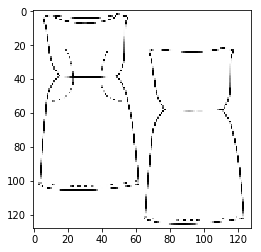

In [477]:
image.resize(128,128)
img = Image.fromarray(image)
plt.imshow(img)

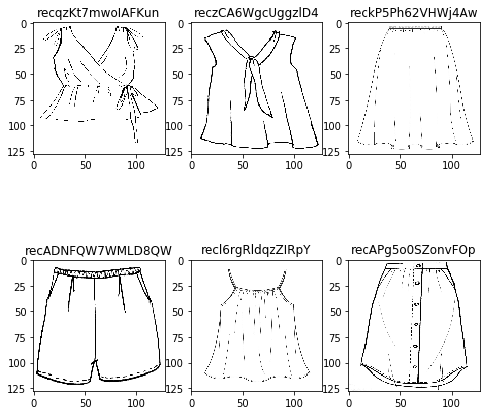

In [532]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img_array = feature[inds[i-1]][:]
    img_array.resize(128,128)
    img = Image.fromarray(img_array)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(neighbors[i-1])
plt.show()

Above are the six neighbors of the target image.
        
        Obviously, they are all Fit Relaxed, Detail Soft and Sleeve None as tagged.

## 3) Now Label all the images in the dataset

In [530]:
'''
Now label all iamges and save the table as a .csv file
'''
#data = pd.read_csv('Body-Grid_view_labeled.csv', index_col=0) #open when restore labelling
count = 0 
for image_name in os.listdir('body_test'):
    ind =  image_name[:-4]
    image_path = os.path.join('body_test', image_name)
    if image_path == 'body_test/.DS_Store':
        continue
    if len(str(data["TAG: Body"].iloc[data[data['id'] == ind].index[0]]))<4:
        image = image_to_feature_vector(image_path)
        inds, neighbors = getNeighbors(feature,image)
        tags = get_tags(neighbors)
        data["TAG: Body"].iloc[data[data['id'] == ind].index[0]] = tags
    else: pass
    count = count + 1
print 'all finished'
print "there are " + str(count) + " new labels created"

all finished
there are 512 new labels created


In [486]:
data.head()

,Body Name,IMAGE,Product Tags: Body,Core Body Number,TAG: Body,id
0,ZIP HOODIE,EH2KTK9Qeer0hHk66aon_Screen%20Shot%202018-01-0...,NaN,CM-3003,"Use Day, Use Weekend, Use Work, Fit Relaxed, D...",recS4t29J73BYrznq
1,Zip BaseBall Jacket,uZNESfIgQLu2lhCVJy2X_Screen%20Shot%202017-12-2...,NaN,CM-4001,"Use Day, Use Work, Body Top 3, Length Medium, ...",recLupRsEop46s4ME
2,Zara Girl's Dress Shirt,CuVfganJSF6x3NCSZuWQ_RM%20PLACEHOLDER.jpg (htt...,NaN,RM-3001,"Use Day, Use Weekend, Use Work, Fit Relaxed, B...",recujzUss1l8UxyjY
3,Zara Girl's Bottom,i6nSRSDdRgaVGrvSvLnM_RM%20PLACEHOLDER.jpg (htt...,NaN,RM-2001,"Use Day, Use Weekend, Use Work, Fit Relaxed, B...",recJo98wKtjScdpxy
4,Zara Boy's Dress Shirt,ww1VVxblTKnWsQGP0zL1_RM%20PLACEHOLDER.jpg (htt...,NaN,RM-3000,"Use Day, Use Weekend, Use Work, Fit Relaxed, B...",reczC3Lul6lJNkOvG


In [487]:
data.tail()

,Body Name,IMAGE,Product Tags: Body,Core Body Number,TAG: Body,id
655,"1 1/2"" SUSPENDERS CLIP ON 54""",Cap8on5CT6iQoBf095ow_DOM_3696.jpg (https://dl....,NaN,JR-8012,"Use Day, Detail Soft, Use Work, Use Weekend, F...",recHwQ7teCZ612w92
656,"1 1/2"" SUSPENDERS BUTTON ON 54""",YCEpMPeCSGGGQGxgNqnn_JR3001_CTSHR_BLBRPL_Blue_...,NaN,JR-8010,"Use Day, Detail Soft, Use Weekend, Use Work, F...",recpleTM3cEbTcf8T
657,"1 1/2"" SUSPENDERS BUTTON ON 48""",7IHcRisYT9u8Ck4HsVq8_DOM_3711.jpg (https://dl....,NaN,JR-8009,"Use Day, Detail Soft, Use Work, Body Top 3, Us...",rechpeWaBJvU5Ag88
658,"1 1/2"" clip on suspender, 48""",5sPST4w9S96T2Xc4IKm1_JR3001_CTSHR_BLBRPL_Blue_...,NaN,JR-8008,"Use Day, Detail Soft, Body Top 3, Fit Relaxed,...",recwBUyecSIFNPDb0
659,Classic fit short sleeve with Short Kent Collar,fKpyAcTxugCeYz5UkFIA_wy%20SHORT%20SLEEVE.jpg (...,NaN,JR-3040,"Use Day, Use Weekend, Use Work, Fit Relaxed, D...",recLGHvJQ9CPaTHxB


In [482]:
data.to_csv("Body-Grid_view_labeled.csv")

### 3.1) Label results

The whole dataset is labeled if there is a attached image of each sample and the labeled dataset is saved as **Body-Grid_view_labeled.csv**.

There are **512** new labels created in the **body** dataset. 

In [4]:
my_list = list(data['TAG: Body'][-data['TAG: Body'].isnull()])
string = str(my_list)
string = string.replace("'","")
string = string.lower()

### 3.2) Visualizations of the results

#### 3.2.1) Word cloud of the body tage

<Figure size 600x400 with 0 Axes>

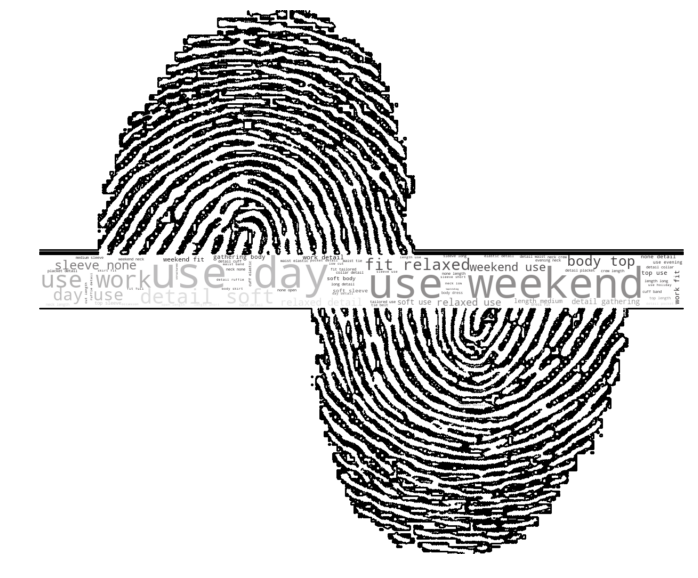

<Figure size 600x400 with 0 Axes>

In [9]:
mask = np.array(Image.open("rea_mask.png"))
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white", max_words=2000,stopwords = stopwords,
               mask=mask,contour_width=3, contour_color='black').generate(string)
image_colors = ImageColorGenerator(mask)
wc.recolor(color_func = image_colors).to_file("wc_rea_body.png")
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

<Figure size 600x400 with 0 Axes>

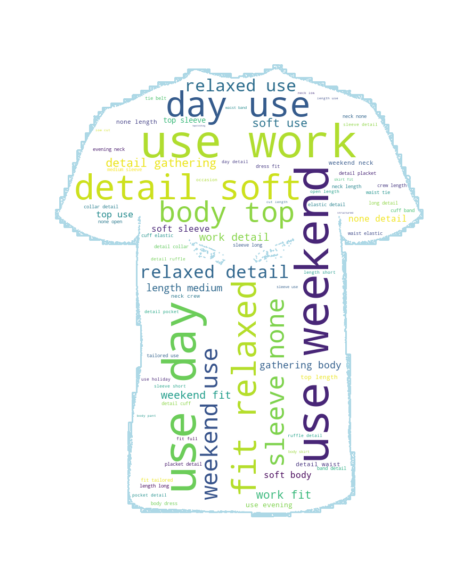

<Figure size 600x400 with 0 Axes>

In [10]:
mask = np.array(Image.open("dp_mask.png"))
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white", max_words=2000,stopwords = stopwords,
               mask=mask,contour_width=3, contour_color='lightblue').generate(string)
image_colors = ImageColorGenerator(mask)
wc.to_file("wc_dp_body.png")
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

#### 3.2.2) Top body tag and the bar plot of them

In [11]:
my_list = list(string.lower().split(','))
counter=collections.Counter(my_list)
df = pd.DataFrame({'body':counter.keys(),'freq':counter.values()})
df = df.sort_values('freq',ascending = False)
not_list = [" "]
for word in not_list:
    df = df[- (df['body'] == word)]
df.head(10)

,body,freq
12,use day,586
18,use weekend,573
35,use work,569
13,detail soft,541
0,fit relaxed,489
4,body top 3,344
2,sleeve none,285
44,detail gathering,210
29,length medium,154
28,use evening,68


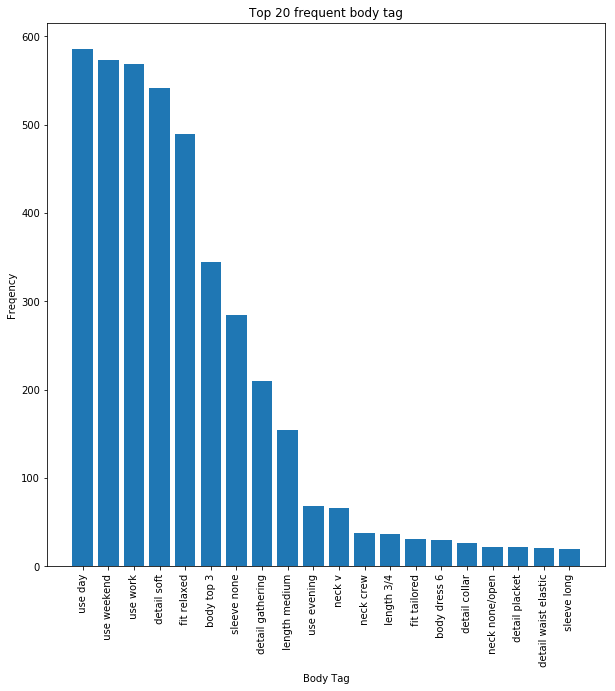

In [16]:
col = df.head(20)['body']
freq = df.head(20)['freq']
plt.figure(figsize=(10,10))
#plt.figure(figsize=(15,15))
index = np.arange(len(col))
plt.bar(index, freq)
ax = plt.gca()
plt.xlabel('Body Tag')
plt.ylabel('Freqency')
plt.xticks(index, col, fontsize = 10,rotation=90)
plt.title('Top 20 frequent body tag')
#plt.savefig("barplot_body.png")
plt.show()

## Thank you!